# Perturbation Expression Plot

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3


In [3]:
# replicate Meshal's pretty plotting colors
from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
%%time
# consider loading as already split
adata1 = sc.read_h5ad('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/210118_annot_patient_1_2.h5ad')
adata2 = sc.read_h5ad('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/210118_annot_patient_3_4.h5ad')
print(adata1)
print(adata2)

AnnData object with n_obs × n_vars = 123768 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'leiden_coarse', 'leiden_coarse1', 'celltype_coarse', 'celltype_fine'
    var: 'gene_ids', 'feature_types', 'genome', 'viral', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'celltype_coarse_colors', 'celltype_fine_colors', "dendrogram_['leiden_coarse1']", 'hvg', 'identifier_colors', 'leiden', 'leiden_coarse1_colors', 'leiden_coarse_colors', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 231731 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral

## Differential expression plots per cell type

In [5]:
import diffxpy.api as de

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [101]:
pd.crosstab(adata2.obs.treatment, adata2.obs.cell_type)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cell_type           basal  basal?  ciliated  ionocytes  secretory    unk
treatment                                                               
BB94                 1049     175       210         11        673   1780
DMSO                  580      94       107          5        462   1037
Gilteritinib         1097     188       204          7        653   1783
IFNL                 2366     220       265         32       5278   1195
IFNa (b_d)           2350     160       245         25       4423   1577
IFNa_TNFa            3255     190       421         38       5604   1578
IFNg                 3267     207       271         34       3724   3053
IFNg_TGFb2           2888     231       251         34       3139   2151
Sorafenib            4253     324       342         24       2627   3394
TGFb2                3740     234       269         26       2163   3805
TGFb2_Tirapazamine   3132     207       254         21       1813   3186
TNFa                 3384     137       283         36       2349   3787
TNFa_IFNg            2238     184       344         36       3118   2209
TNFa_TGFb2           2889     223       320         26       2130   3497
TNFa_Tirapazamine    2695     158       302         15       2025   3262
Tirapazamine         3671     209       340         45       2329   3814
mock                 6290     380       415         65       4130   7616
nan                 17246    1451      4376        311      33212  21783

Using rank_genes_groups.

In [28]:
from gprofiler import GProfiler

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
def enrich(query):
    gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')

    return gp.profile(
        organism='hsapiens', sources=['GO:BP'], user_threshold=0.05,
        significance_threshold_method='fdr', 
        background=adata1.var_names.tolist(),
        query=query)

In [125]:
sns.set(font_scale=1.4)

In [160]:
enr_dfs = {}
terms = []
for ct in ['basal', 'ciliated', 'secretory']:
    subset = adata2[adata2.obs.cell_type == ct]
    sc.tl.rank_genes_groups(subset, groupby='treatment', reference='nan', use_raw=False)
    
    for group in subset.obs.treatment.unique():
        if group != 'nan':
            enr_dfs[f'{ct}_{group}'] = enrich(sc.get.rank_genes_groups_df(subset, group=group)['names'][:50].values.tolist())
            terms += enr_dfs[f'{ct}_{group}'].sort_values('p_value').iloc[:1,:]['name'].values.tolist()
#            terms += enr_dfs[f'{ct}_{group}'][enr_dfs[f'{ct}_{group}']['p_value'] < .00000000000001].sort_values('p_value')['name'].values.tolist()

ct_dfs = {}       
for ct in ['basal', 'ciliated', 'secretory']:
    dfs = []
    for group in subset.obs.treatment.unique():
        if group != 'nan':
            df = enr_dfs[f'{ct}_{group}']
            df = df[df.name.isin(terms)][['name', 'p_value']]
            df[group] = -np.log10(df['p_value'])
            df = df.set_index('name').drop(columns=['p_value'])
            dfs.append(df)

    ct_dfs[ct] = pd.concat(dfs, axis=1).fillna(0)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


Trying to set attribute `.uns` of view, copying.


dict_keys(['basal', 'ciliated', 'secretory'])


<AxesSubplot:ylabel='name'>

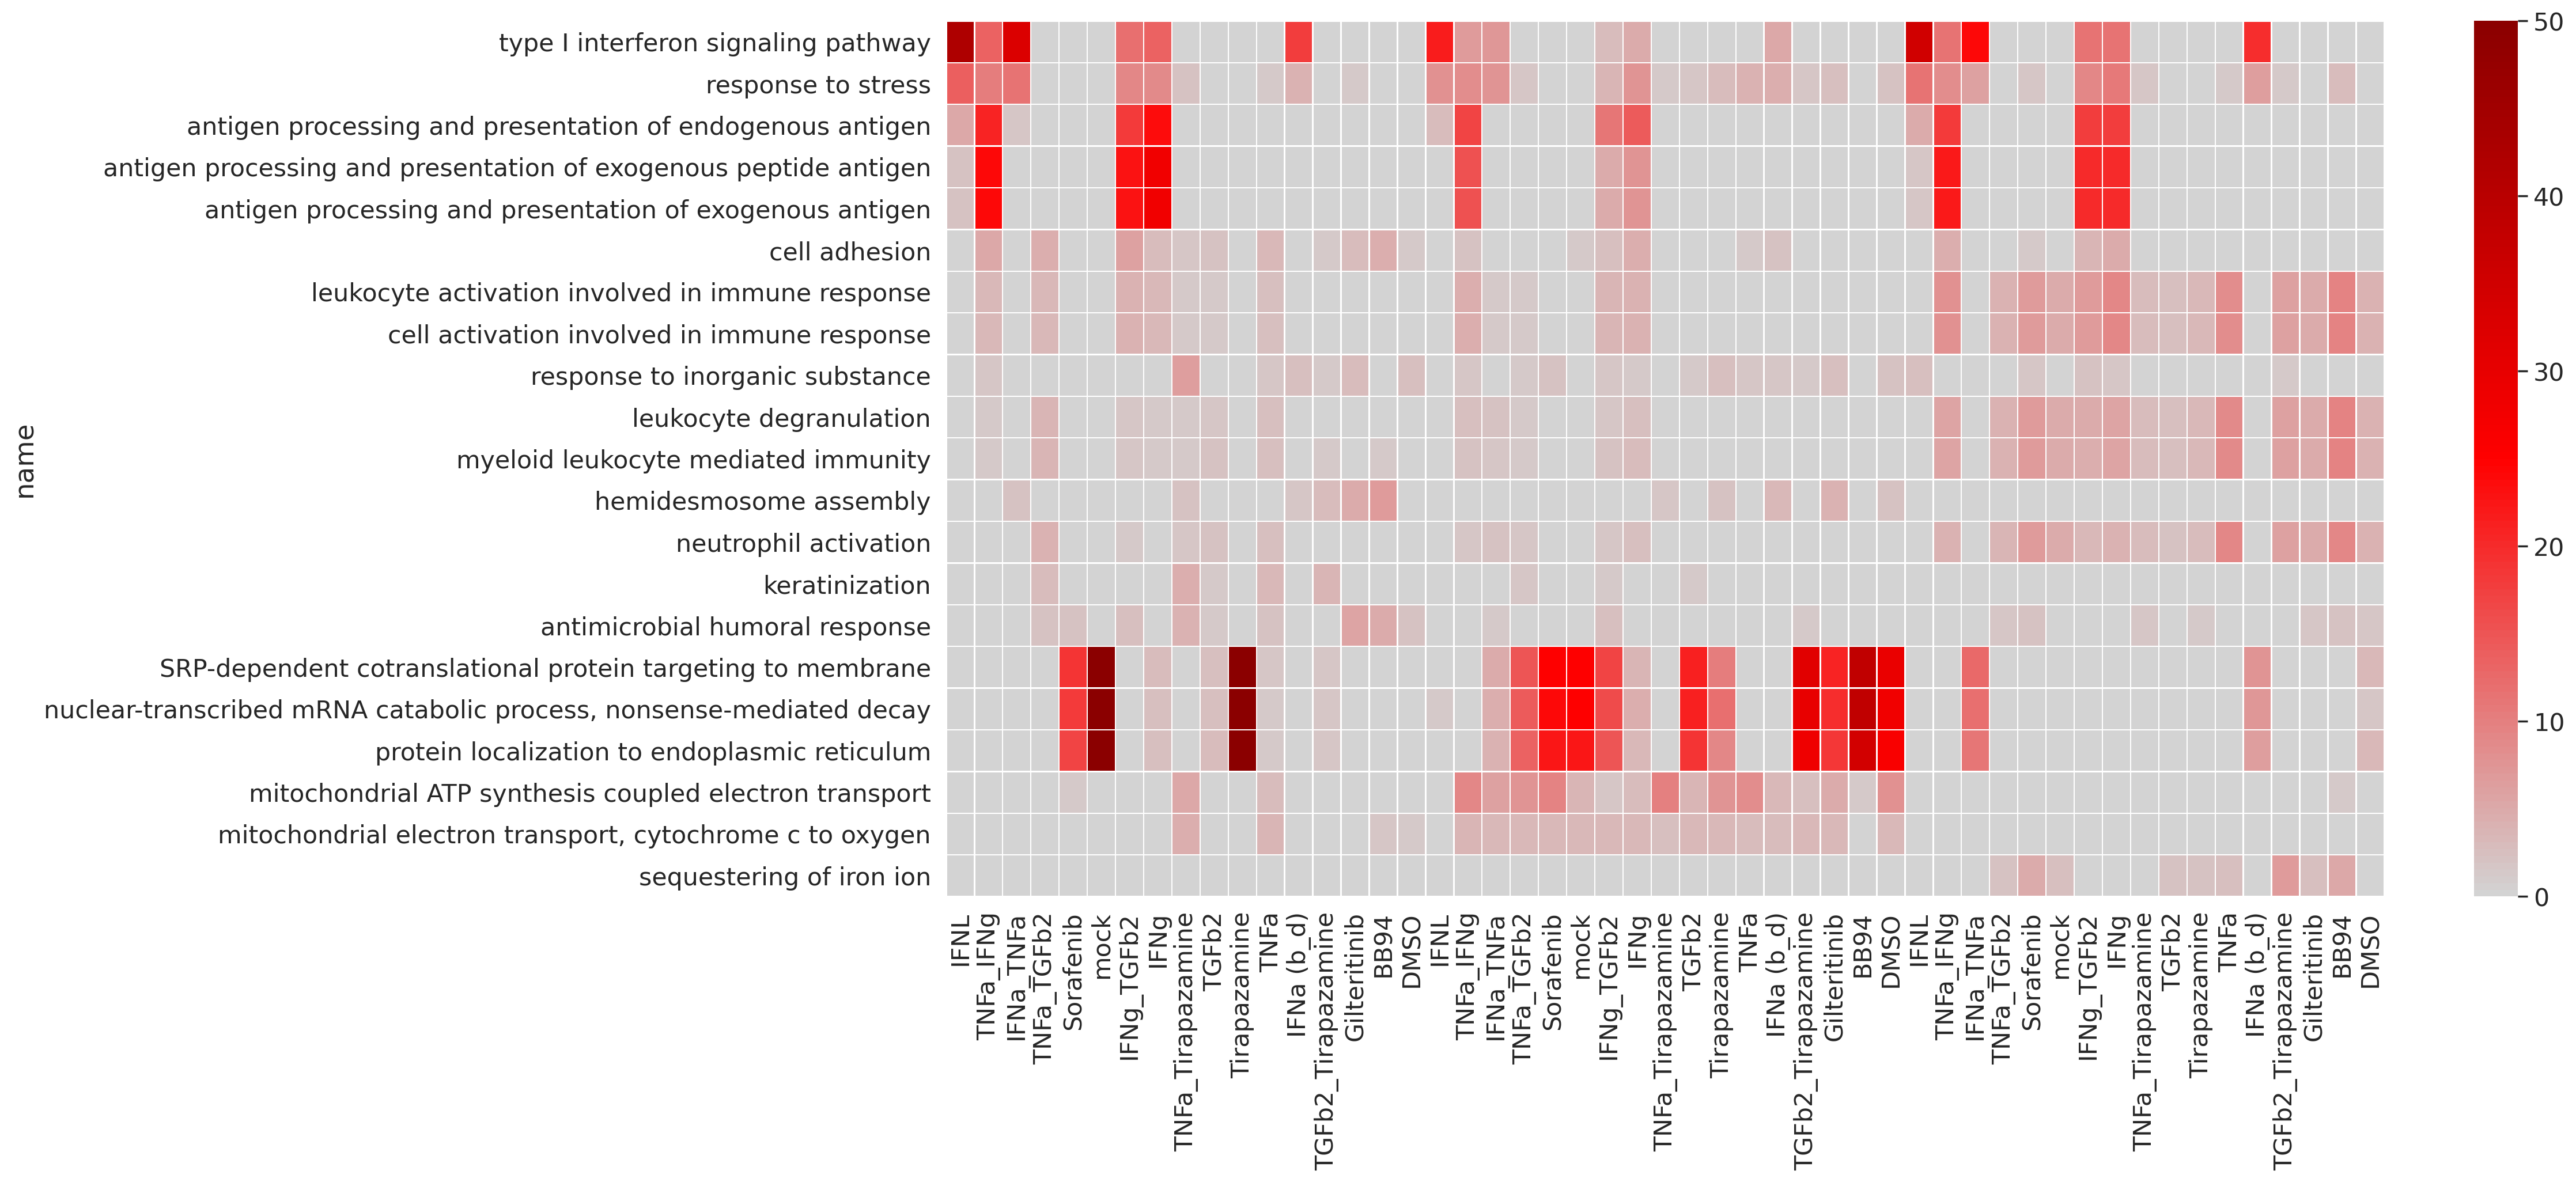

In [212]:
plt.figure(figsize=(20, 10))
print(ct_dfs.keys())
sns.heatmap(pd.concat(ct_dfs.values(), axis=1).fillna(0), cmap=gray_red, linewidths=.5, vmax=50)

## diffxpy

In [10]:
test_tt = de.test.t_test(
    data=adata1,
    grouping="treatment",
    is_logged=True,
)

In [12]:
test_tt.summary()

gene          pval          qval    log2fc      mean  zero_mean  \
0           SAMD11  3.790490e-01  6.238263e-01 -0.000447  0.000616      False   
1            NOC2L  4.741195e-03  3.390814e-02 -0.015027  0.069608      False   
2           KLHL17  9.122405e-01  9.596778e-01  0.000283  0.013245      False   
3          PLEKHN1  1.708339e-09  5.266646e-08 -0.031212  0.067945      False   
4            PERM1  1.796075e-01  4.372093e-01 -0.001870  0.005223      False   
...            ...           ...           ...       ...       ...        ...   
18110  ORF7a-minus  3.173105e-01  5.636905e-01  0.000064  0.000012      False   
18111  ORF7b-minus           NaN           NaN  0.000000  0.000000       True   
18112   ORF8-minus  3.173105e-01  5.636905e-01 -0.000089  0.000045      False   
18113      N-minus  9.142188e-01  9.606473e-01 -0.000244  0.004545      False   
18114  ORF10-minus  3.430291e-02  1.512738e-01 -0.000554  0.000338      False   

       zero_variance  
0              False  
1              False  
2              False  
3              False  
4              False  
...              ...  
18110          False  
18111           True  
18112          False  
18113          False  
18114          False  

[18115 rows x 7 columns]

In [13]:
test_tt.summary().sort_values(by='pval')

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


gene           pval           qval    log2fc      mean  \
17461       RPS4Y1   0.000000e+00   0.000000e+00 -0.560973  0.565706   
5863      HLA-DRB1  2.904212e-229  2.435327e-225  0.643548  1.140255   
4167       SLC34A2  4.065911e-186  2.272980e-182  0.528767  0.733617   
5356          CD74  1.296571e-171  5.436197e-168  0.560878  1.898809   
3843       RARRES1  5.078776e-158  1.703523e-154  0.772034  2.328509   
...            ...            ...            ...       ...       ...   
18090   AC023491.2            NaN            NaN  0.000000  0.000000   
18107      E-minus            NaN            NaN  0.000000  0.000000   
18108      M-minus            NaN            NaN  0.000000  0.000000   
18109   ORF6-minus            NaN            NaN  0.000000  0.000000   
18111  ORF7b-minus            NaN            NaN  0.000000  0.000000   

       zero_mean  zero_variance  
17461      False          False  
5863       False          False  
4167       False          False  
5356       False          False  
3843       False          False  
...          ...            ...  
18090       True           True  
18107       True           True  
18108       True           True  
18109       True           True  
18111       True           True  

[18115 rows x 7 columns]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


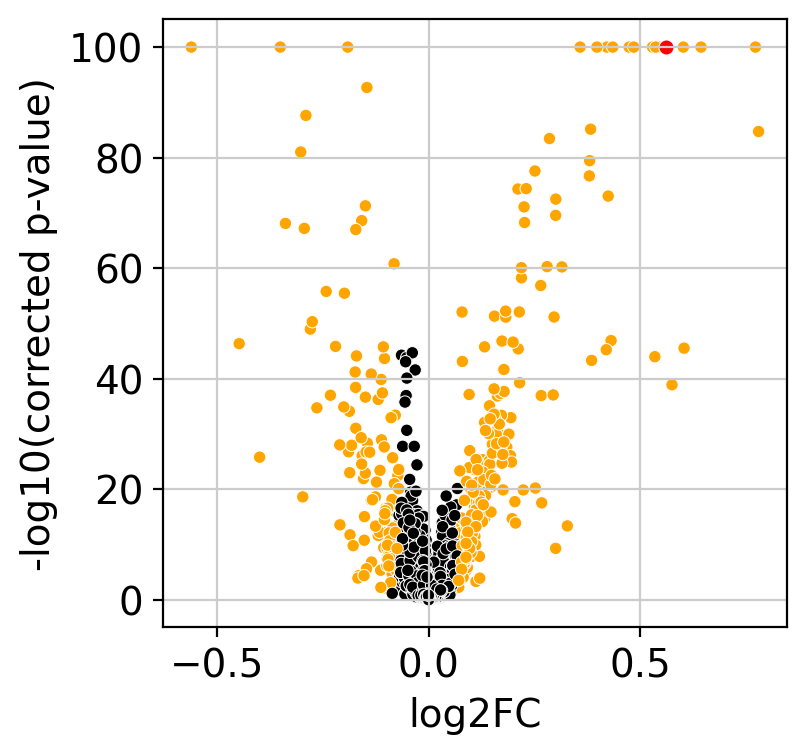

In [14]:
test_tt.plot_volcano(
    corrected_pval=True, min_fc=1.05, alpha=0.05, size=20, log10_p_threshold=-100, log2_fc_threshold=10,
    highlight_ids=['CD74'])

In [ ]:
test_tt.plot_volcano(
    corrected_pval=True, min_fc=1.05, alpha=0.05, size=20, log10_p_threshold=-100, log2_fc_threshold=10,
    highlight_ids=['CD74'])

Previous multi-coeff names...?

In [40]:
%%time
test_tt = de.test.pairwise(
    data=adata1,
    grouping='treatment',
    test='t-test'
)

ValueError: lazy evaluation of pairwise tests only possible if test is z-test

In [ ]:
test_tt = 

# Co-correlation of genes

In [5]:
adata2 = adata2.T.copy()

sc.pp.pca(adata2)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


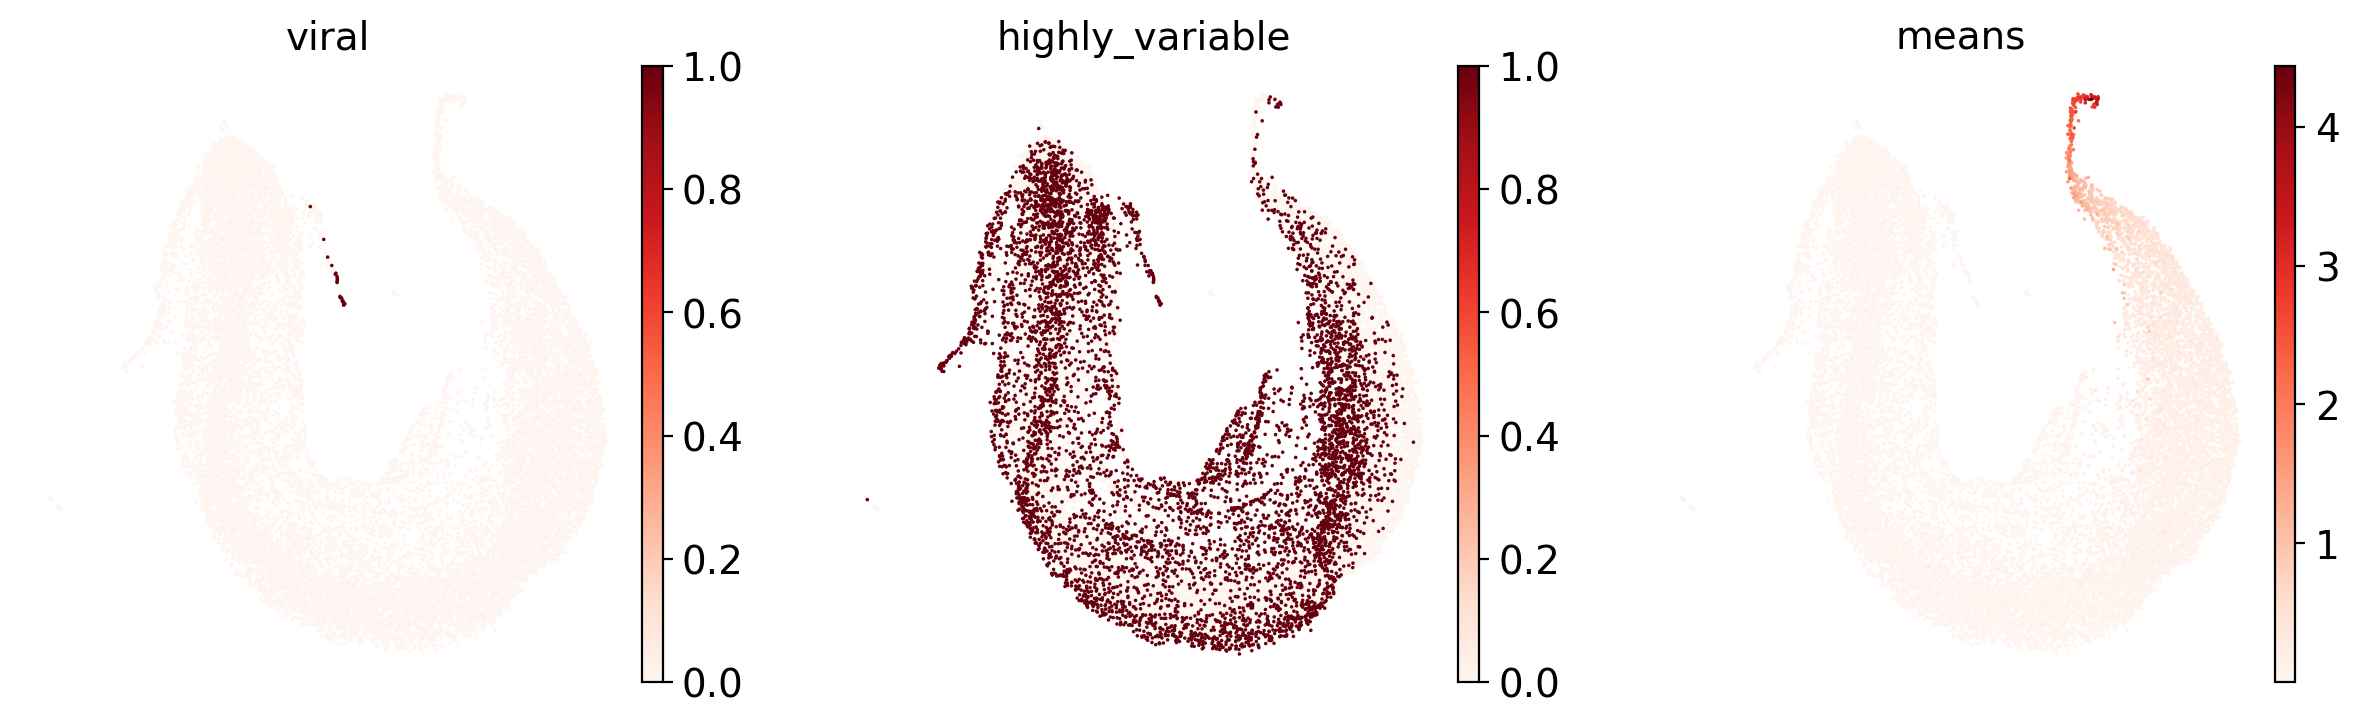

In [6]:
sc.pl.umap(adata2, color=['viral', 'highly_variable', 'means'])

1. determine covarying gene programs on cell type level separetely for each of the three replicate experiments

In [26]:
adata2 = sc.read_h5ad('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/210118_annot_patient_3_4.h5ad')

In [27]:
adata2.obs.treatment.value_counts()

nan                   78379
mock                  18896
IFNa_TNFa             11086
Sorafenib             10964
IFNg                  10556
Tirapazamine          10408
TGFb2                 10237
TNFa                   9976
IFNL                   9356
TNFa_TGFb2             9085
IFNa (b_d)             8780
IFNg_TGFb2             8694
TGFb2_Tirapazamine     8613
TNFa_Tirapazamine      8457
TNFa_IFNg              8129
Gilteritinib           3932
BB94                   3898
DMSO                   2285
Name: treatment, dtype: int64

In [179]:
# subset to mock condition
mock = adata2[adata2.obs.treatment == 'nan']
display(mock.obs.cell_type.value_counts())
mock_T = mock[mock.obs.cell_type == 'secretory'].copy().T.copy()
mock_T = mock_T[mock_T.obs.highly_variable == True]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


secretory    33212
unk          21783
basal        17246
ciliated      4376
basal?        1451
ionocytes      311
Name: cell_type, dtype: int64

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [180]:
%%time
sc.pp.pca(mock_T)
sc.pp.neighbors(mock_T)
sc.tl.umap(mock_T)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 9min 11s, sys: 15.7 s, total: 9min 27s
Wall time: 38.9 s


In [181]:
sc.tl.leiden(mock_T, resolution=.5)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [183]:
mock_T

AnnData object with n_obs × n_vars = 6652 × 33212
    obs: 'gene_ids', 'feature_types', 'genome', 'viral', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'leiden'
    var: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'leiden_coarse', 'leiden_coarse1', 'celltype_coarse', 'celltype_fine', 'batch', 'virus_infected', 'cell_type', 'infected_10'
    uns: 'neighbors', 'umap', 'pca', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'X_pca', 'X_umap', 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'
    varp: 'connectivities', 'distances'

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


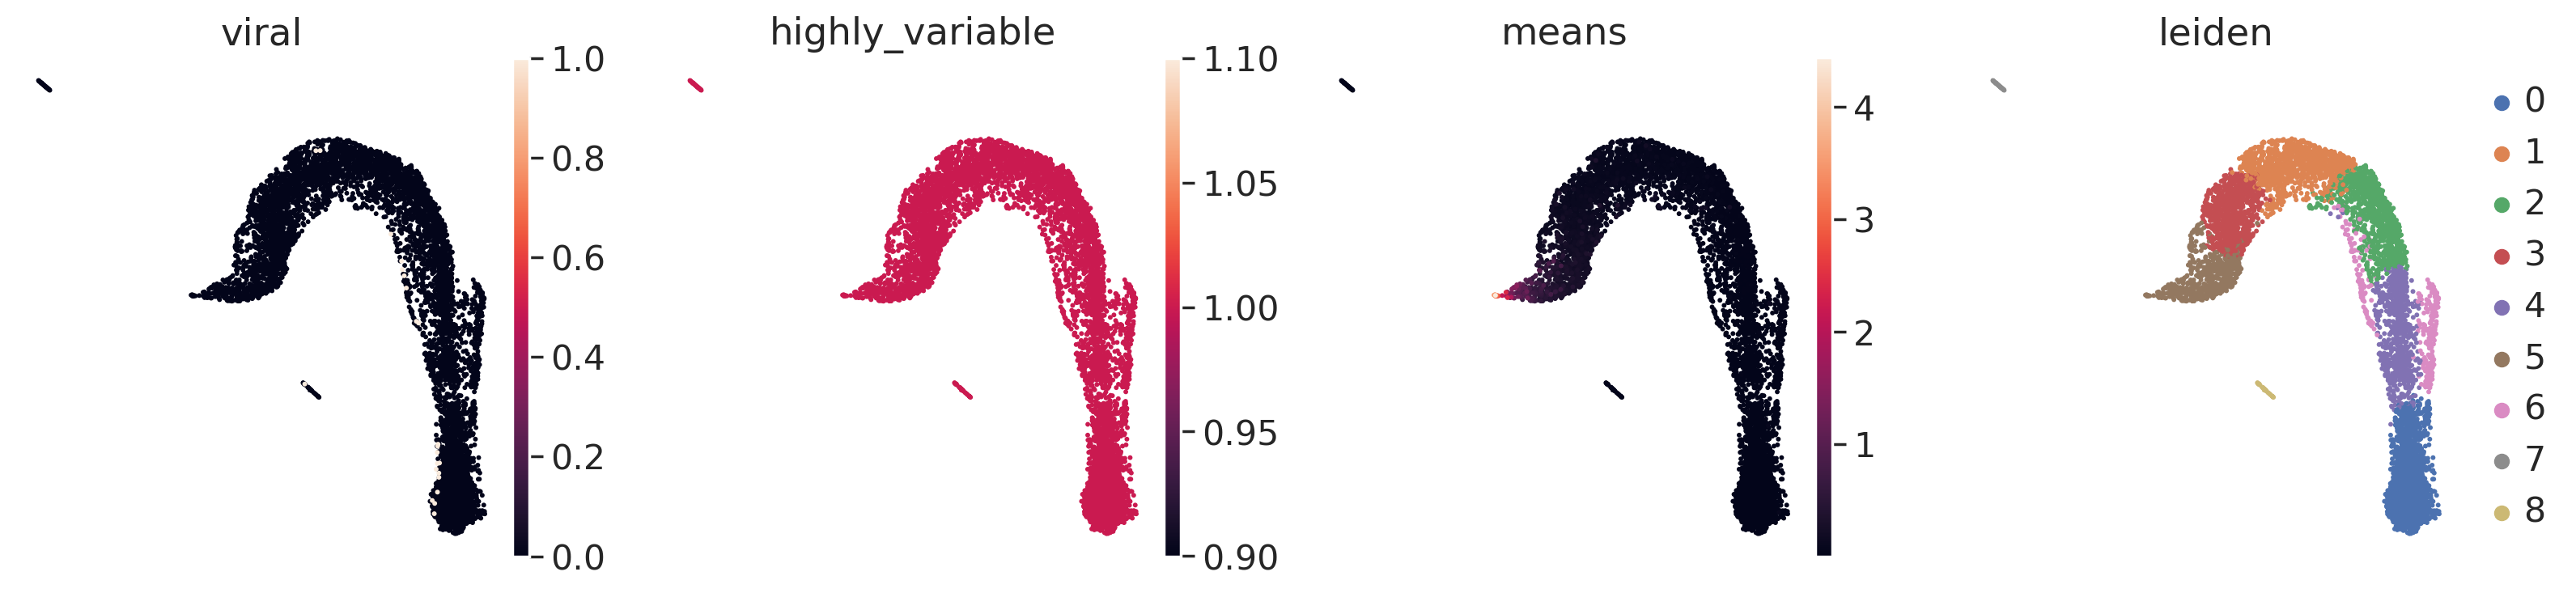

In [182]:
sc.pl.umap(mock_T, color=['viral', 'highly_variable', 'means', 'leiden'])

In [187]:
df = adata2[:, adata2.var.highly_variable].to_df().T
df['leiden'] = mock_T.obs.leiden.values

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [190]:
mock = mock_T.T.copy()

In [192]:
exp = df.groupby('leiden').mean().T
for col in exp.columns:
    mock.obs[col] = exp[[col]]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


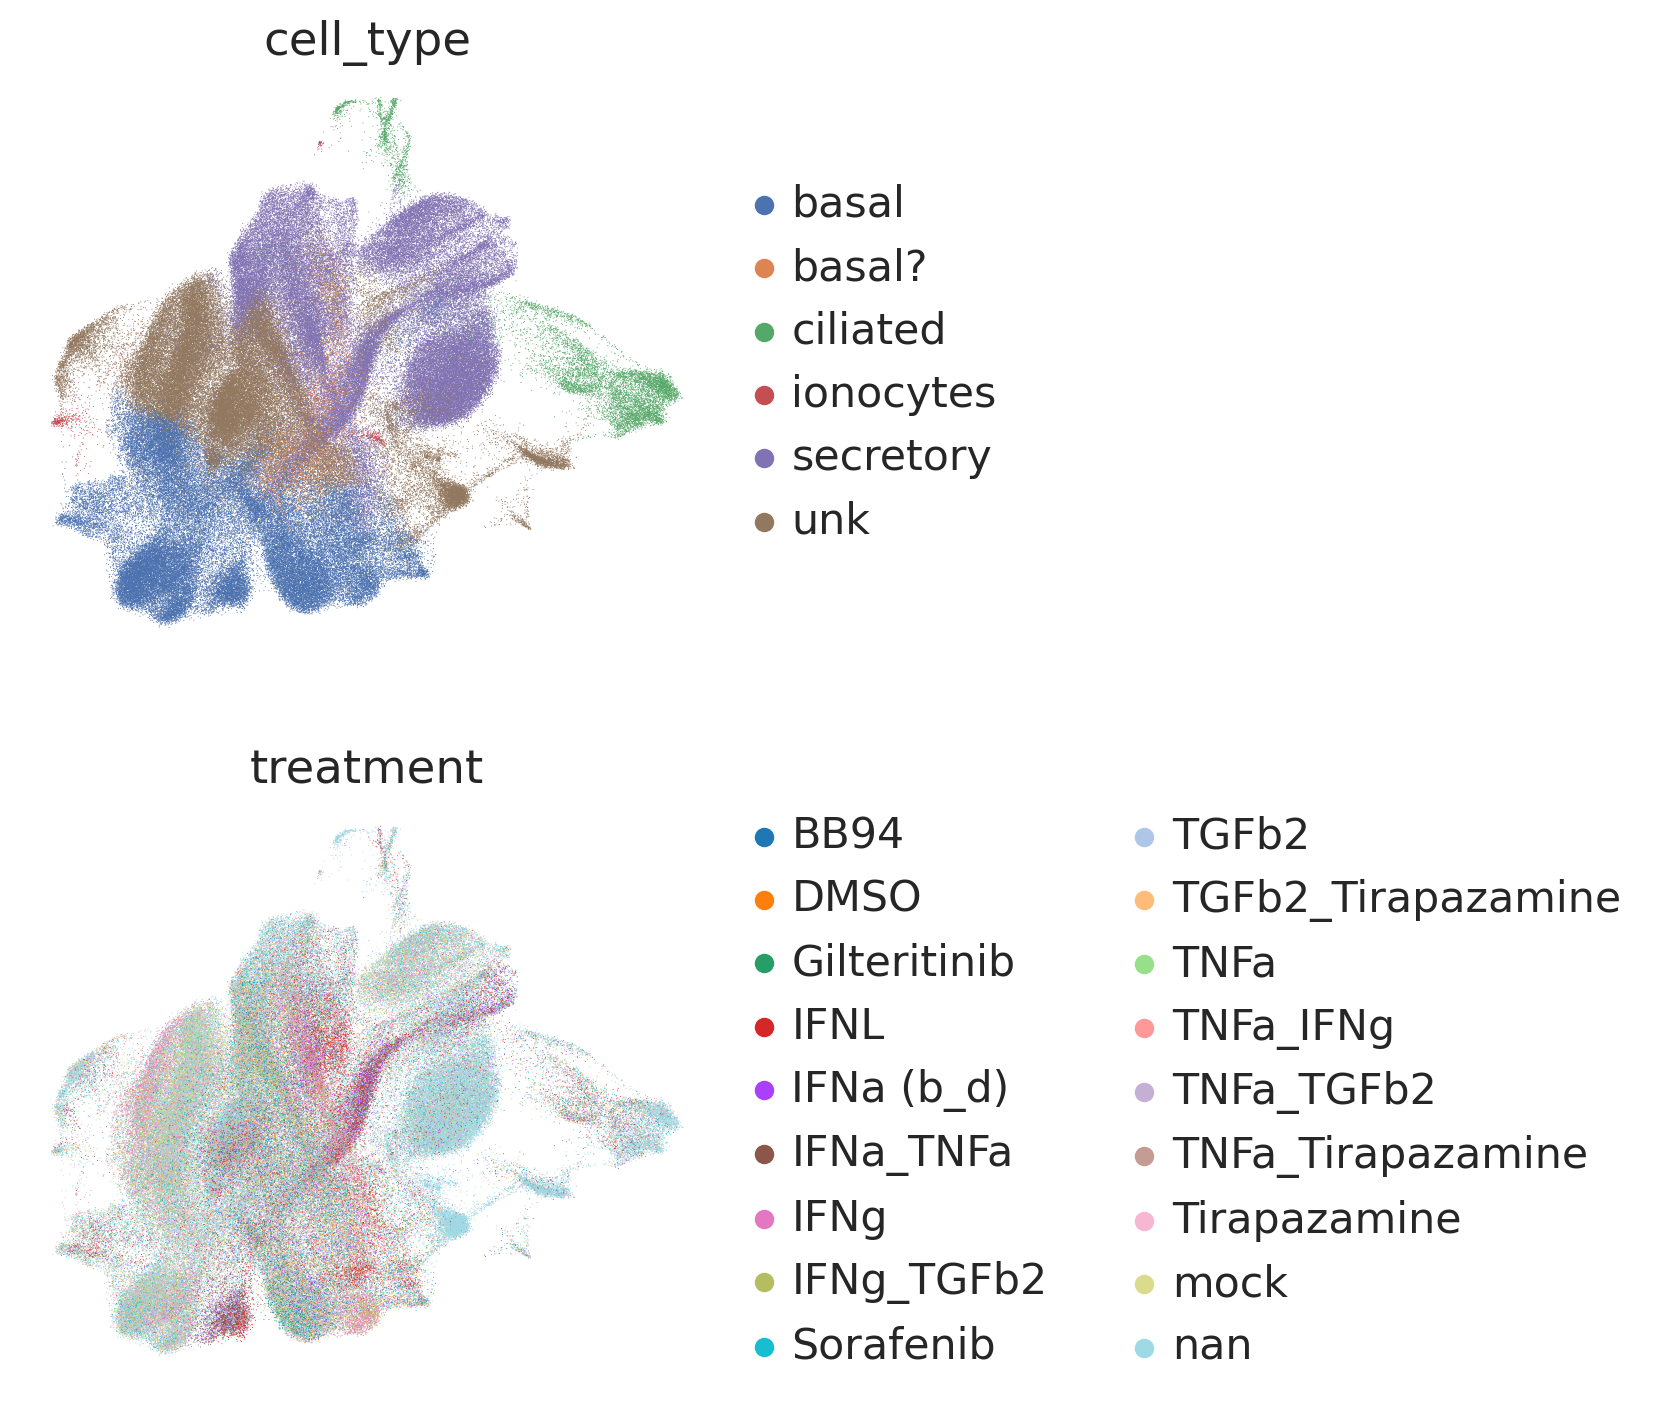

In [209]:
sc.pl.umap(adata2, color=['cell_type', 'treatment'], ncols=1)

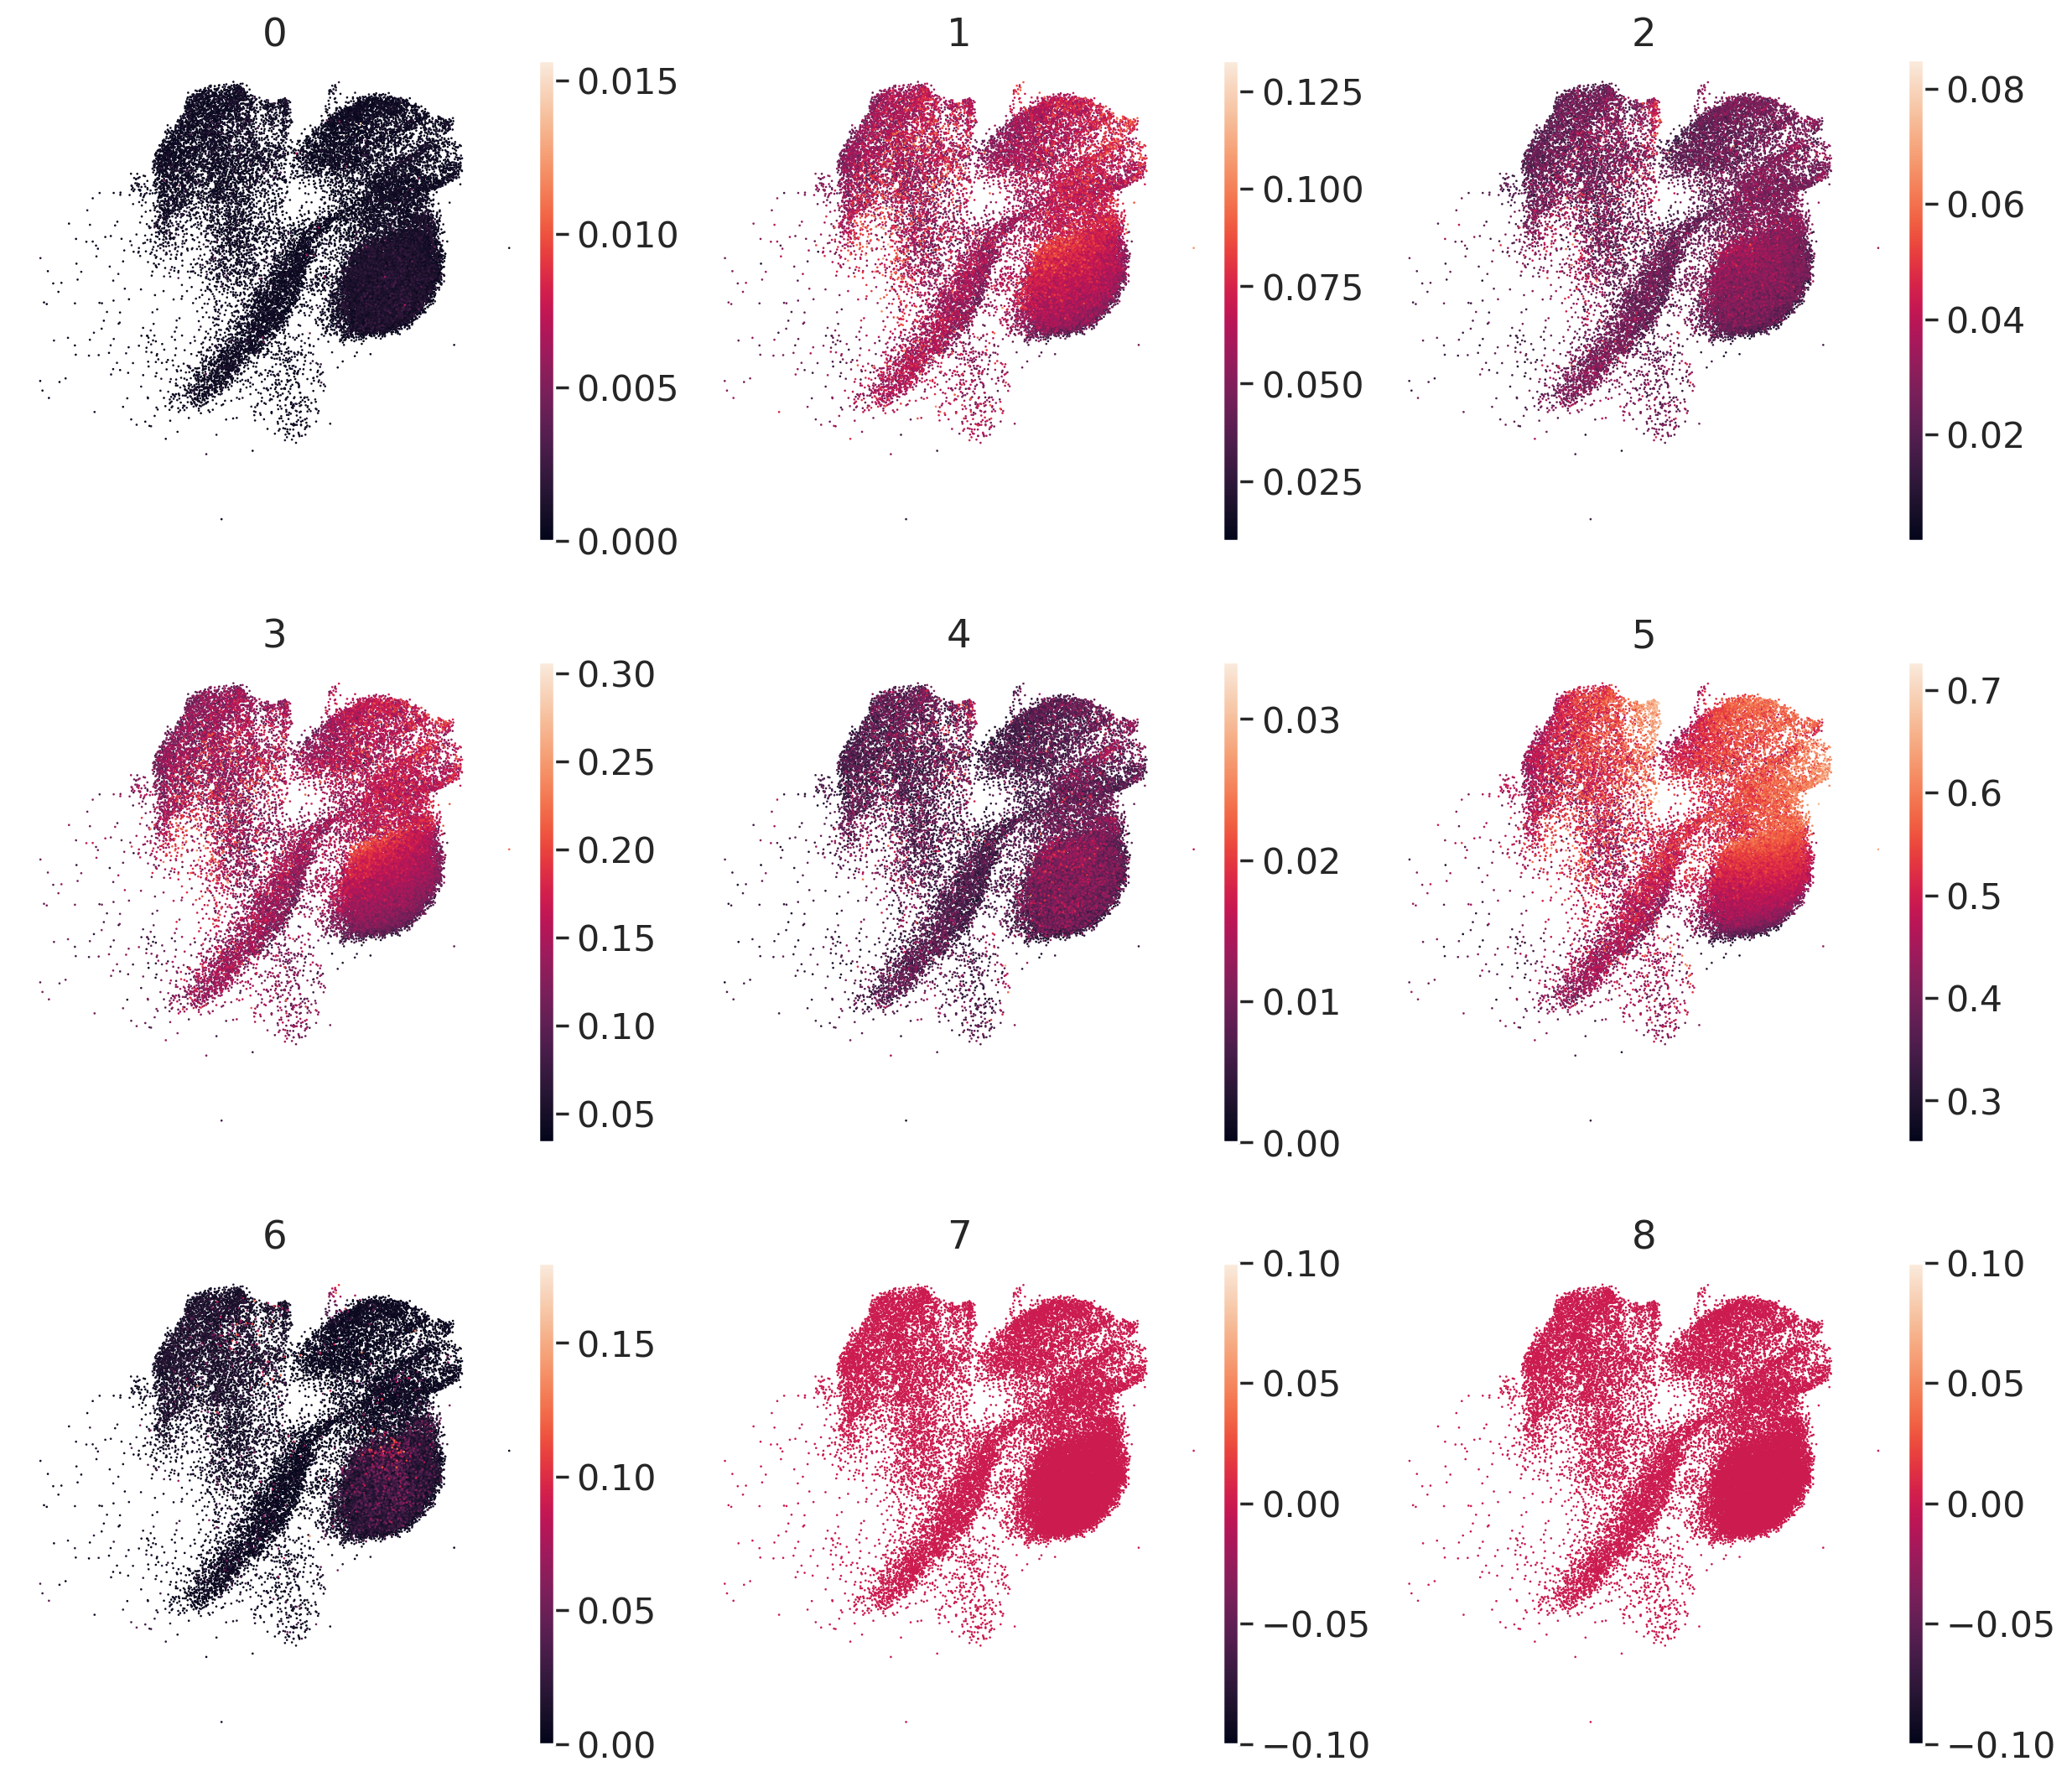

In [206]:
sc.pl.umap(mock, color=['0', '1', '2', '3', '4', '5', '6', '7', '8'], ncols=3)